In [27]:
import numpy as np
import pandas as pd
import glob
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, model_from_json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from bankroll_calc import BankrollCalculator

In [6]:
moneyline_df = pd.read_csv("./moneyline_frame.csv.gz", compression = "gzip")

In [7]:
#load selected feature set 
with open('./selected_features.json', 'r') as f:
    selected_features = json.load(f)

In [8]:
#extract feature set (determined in feature selection )
moneyline_df = moneyline_df[selected_features]

# EDA discovery

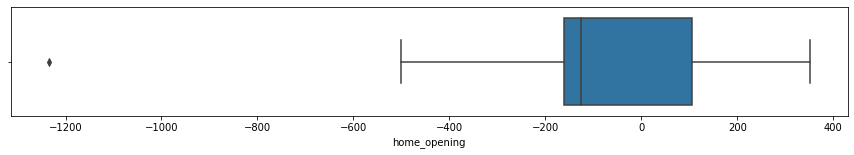

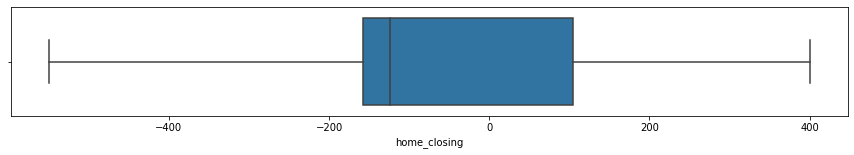

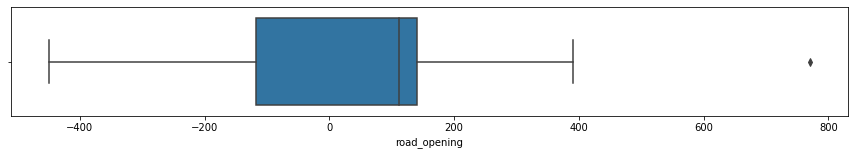

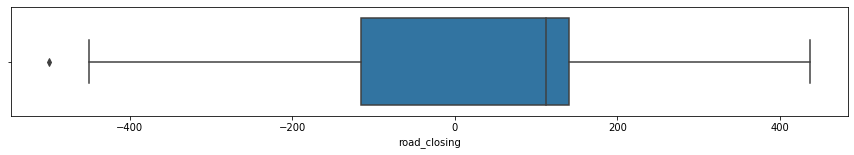

In [9]:
#view distributions of odds features
odds_features = ['home_opening', 'home_closing', 'road_opening', 'road_closing']
for feature in odds_features:
    plt.figure(figsize = (15, 2))
    sns.boxplot(x = moneyline_df[feature])

In [10]:
#view concerning datapoints
problem_set = moneyline_df[(moneyline_df.home_opening < - 1000) | (moneyline_df.road_opening > 600)]
problem_set

,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,...,run_differential_rd,avg_margin_rd,home_opening,home_closing,road_opening,road_closing,home_win,year,home_season_ERA_AH,date
22320,0.741787,4.642857,7.285714,4.287983,1.517558,0.691507,3.75,7.8125,3.288462,1.269231,...,-6.0,0.0,-1235.0,-124.0,770.0,114.0,1,2019,3.069577,2019-05-04


This game opened at $-1235/+770$ and was either bet down to $-124/+114$... This is not a realistic gambling scheme, and I cannot determine without further research what caused this, so I will be removing this datapoint.

In [11]:
moneyline_df = moneyline_df.drop(problem_set.index, axis = 0).reset_index(drop = True)

In [12]:
pd.set_option('max.columns', 50)
moneyline_df.describe()

,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,home_career_ERA_AH,home_career_WHIP_AH,road_career_ERA_OR,road_career_WHIP_OR,road_season_ERA_OR,road_season_WHIP_OR,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,home_opening,home_closing,road_opening,road_closing,home_win,year,home_season_ERA_AH
count,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000
mean,0.726230,4.363696,8.407522,3.720565,1.268089,0.699715,4.273058,8.539405,3.874378,1.315953,3.819628,1.250172,4.213090,1.325101,3.912480,1.203699,-0.036156,0.274324,2.657610,4.055904,0.047287,-0.421834,-0.275932,-2.649819,-4.044855,-0.060026,-68.519583,-69.651880,37.600223,37.618816,0.535538,2014.499134,3.551979
std,0.108697,1.053112,1.368092,1.394584,0.252873,0.100118,0.989404,1.331755,1.423701,0.264731,1.579010,0.310012,1.866187,0.338238,3.130964,0.601791,2.333654,2.519179,8.678199,38.878951,0.969601,2.148591,2.572857,8.336525,38.485959,0.974729,133.235040,135.807434,136.753525,139.904942,0.498746,2.871795,2.905983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000,-12.000000,-36.000000,-215.000000,-15.000000,-17.000000,-17.000000,-46.000000,-208.000000,-15.000000,-500.000000,-550.000000,-450.000000,-500.000000,0.000000,2010.000000,0.000000
25%,0.693520,3.827586,7.969697,2.995402,1.169437,0.673702,3.833333,8.136364,3.147268,1.209591,3.228511,1.159693,3.621412,1.240722,2.454545,1.041667,-1.000000,-1.000000,-2.000000,-17.000000,0.000000,-2.000000,-2.000000,-7.000000,-23.000000,0.000000,-160.000000,-158.000000,-117.000000,-115.000000,0.000000,2012.000000,2.084245
50%,0.732817,4.356164,8.482759,3.674208,1.273946,0.704974,4.283019,8.630286,3.813849,1.321358,3.731031,1.265432,4.144943,1.333333,3.785489,1.275862,1.000000,1.000000,2.000000,2.000000,0.000000,-1.000000,-1.000000,-2.000000,-2.000000,0.000000,-125.000000,-124.000000,111.000000,112.000000,1.000000,2014.000000,3.377111
75%,0.776457,4.931034,9.019053,4.368197,1.390679,0.740919,4.730769,9.107692,4.536748,1.432334,4.354670,1.361725,4.680832,1.436379,5.103581,1.499151,1.000000,2.000000,7.000000,25.000000,0.000000,1.000000,1.000000,2.000000,15.000000,0.000000,105.000000,105.000000,140.000000,141.000000,1.000000,2017.000000,4.682622
max,1.441758,17.000000,19.000000,34.763948,5.579399,1.365521,15.000000,19.000000,27.000000,5.970149,80.597015,11.940299,107.462687,14.925373,136.363636,21.212121,11.000000,15.000000,39.000000,174.000000,15.000000,11.000000,15.000000,34.000000,182.000000,15.000000,351.000000,400.000000,390.000000,437.000000,1.000000,2019.000000,136.363636


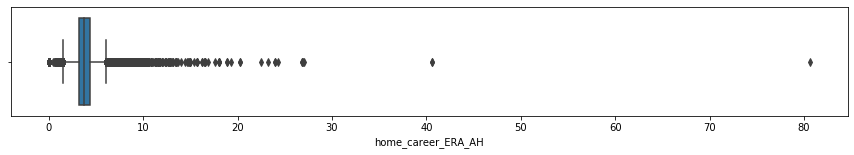

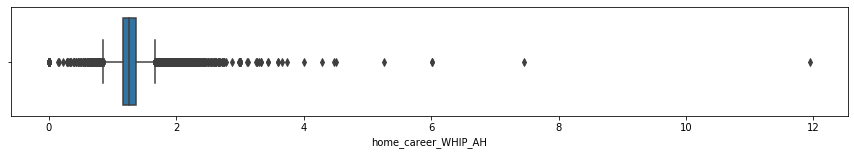

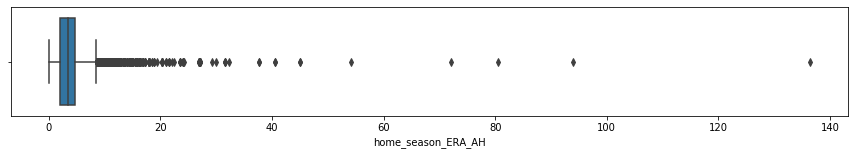

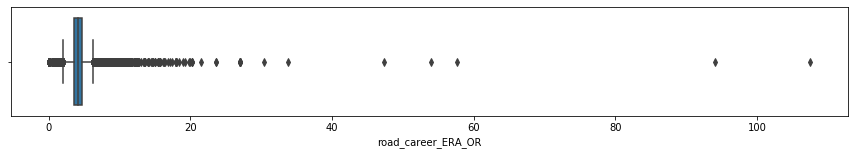

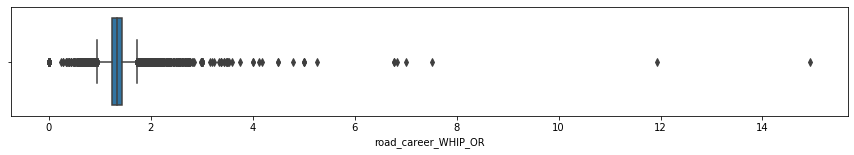

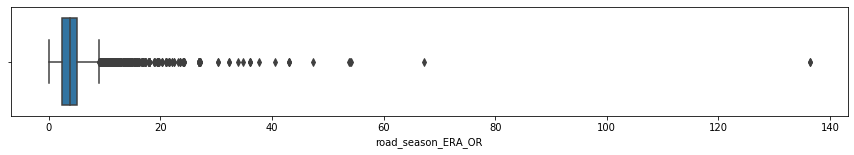

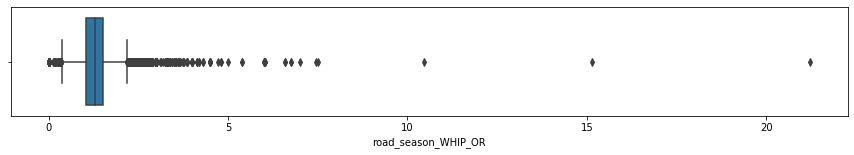

In [13]:
#view distributions of pitching statistics
pitching_stats = ['home_career_ERA_AH', 'home_career_WHIP_AH', 'home_season_ERA_AH', 'road_career_ERA_OR',
                 'road_career_WHIP_OR', 'road_season_ERA_OR', 'road_season_WHIP_OR']
for feature in pitching_stats:
    plt.figure(figsize = (15, 2))
    sns.boxplot(x = moneyline_df[feature])

In [14]:
problem_pitching_indices = moneyline_df[(moneyline_df.road_season_WHIP_OR > 7) | 
                                       (moneyline_df.road_season_ERA_OR > 30) |
                                       (moneyline_df.road_career_WHIP_OR > 6) |
                                       (moneyline_df.road_career_ERA_OR > 30) |
                                       (moneyline_df.home_season_ERA_AH > 30) |
                                       (moneyline_df.home_career_WHIP_AH > 6) | 
                                       (moneyline_df.home_career_ERA_AH > 30)].index
print(len(problem_pitching_indices))

44


One of the issues I am working to correct is the model struggles in the beginning of the season. One potential method of correcting this is removing some of the variance in the early season models, which is what I will try here. If that doesn't work, then I will look into factoring in previous season results.

In [15]:
moneyline_df = moneyline_df.drop(problem_pitching_indices, axis = 0).reset_index(drop = True)

In [16]:
def calculate_totalpayout(df):
    ''' 
    Assuming $1.00 bet for simplicity
    '''
    home_outcome = []
    road_outcome = []
    for k in range(len(df)):
        if df.iloc[k]['home_closing'] < 0:
            home_outcome.append(-100.0 / df.iloc[k]['home_closing'] + 1)
        else:
            home_outcome.append(df.iloc[k]['home_closing'] / 100 + 1)
        if df.iloc[k]['road_closing'] < 0:
            road_outcome.append(-100.0 / df.iloc[k]['road_closing'] + 1)
        else:
            road_outcome.append(df.iloc[k]['road_closing'] / 100 + 1)
    return(pd.Series(home_outcome), pd.Series(road_outcome))

home_payout, road_payout = calculate_totalpayout(moneyline_df)
moneyline_df['home_payout'], moneyline_df['road_payout'] = home_payout, road_payout

In [17]:
training_data = moneyline_df[moneyline_df.year < 2019].drop(columns = ['date', 'year']).reset_index(drop = True)
validation_set = moneyline_df[moneyline_df.year == 2019].drop(columns = ['date', 'year']).reset_index(drop = True)

validation_home_closing = validation_set.home_closing
validation_road_closing = validation_set.road_closing 
validation_dates = moneyline_df[moneyline_df.year == 2019].date.reset_index(drop = True)

train_features = training_data.drop(columns = ['home_win', 'home_payout', 'road_payout'])
train_target = training_data['home_win']
train_weights = training_data[['home_payout', 'road_payout']]

validation_input = validation_set.drop(columns = ['home_win', 'home_payout', 'road_payout'])
validation_target = validation_set['home_win']

## THIS IS A DETOUR. WE ARE LOOKING AT CORRELATION FEATURES ##

In [18]:
#importing FeatureSelector, I want to use several of the functions I wrote in this module to evaluate correlation
from recursive_selection import FeatureSelector
selector = FeatureSelector(train_features, train_target)
drop_cols = selector.get_correlated(train_features, 0.75, 10, 'tol')

In [19]:
#overly correlated columns 
drop_cols

['road_opening',
 'road_closing',
 'road_AVG_H',
 'home_AVG_H',
 'run_differential_rd',
 'home_AVG_RUNS',
 'home_closing',
 'run_differential_hm',
 'road_AVG_RUNS',
 'road_season_WHIP_OR',
 'road_career_WHIP_OR',
 'home_career_WHIP_AH',
 'road_BULLPEN_WHIP',
 'home_BULLPEN_WHIP',
 'current_streak_hm_at_hm']

In [20]:
corr_reduced_train = train_features.drop(columns = drop_cols)
corr_reduced_test = validation_input.drop(columns = drop_cols)

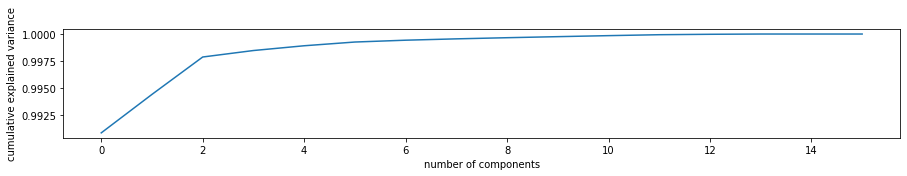

In [21]:
pca = PCA().fit(corr_reduced_train)

plt.figure(figsize = (15, 2))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

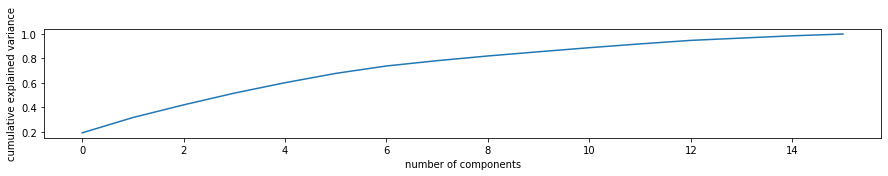

In [22]:
ss = StandardScaler()
scaled_corr_reduced_train = ss.fit_transform(corr_reduced_train)

pca = PCA().fit(scaled_corr_reduced_train)

plt.figure(figsize = (15, 2))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [23]:
cols = corr_reduced_train.columns
scr_train = pd.DataFrame(scaled_corr_reduced_train)
scr_train.columns = cols

In [24]:
ss = StandardScaler().fit(corr_reduced_train)
crt_test = ss.transform(corr_reduced_test)
crt_test = pd.DataFrame(crt_test)
crt_test.columns = cols

In [40]:
#save model and model weights 
json_model = nn.model.to_json()
with open('no_pca.json', 'w+') as f:
    json.dump(json_model, f)
    
nn.model.save_weights("nopca.h5")

In [44]:
train_target = np.array(train_target).astype('float32')
validation_target = np.array(validation_target).astype('float32')

In [ ]:
#wrapper class for designing testing neural networks
class NeuralNet():
    def __init__(self, training, target_train, validation, target_validation, n_hidden = 2, neurons = 50, 
                 model_checkpoint = False, checkpoint_params = None, early_stopping = False, 
                 early_stopping_params = None, dropout = True, retention = 0.5, activation = 'relu', 
                 compile_params = {'optimizer' : 'adam', 'loss' : 'binary_crossentropy', 
                                   'metrics' : ['binary_accuracy']}, 
                 fit_params = {'epochs' : 50, 'validation_split' : 0.2, 'verbose' : 0}):
        self.training = training
        self.target_train = target_train
        self.validation = validation
        self.target_validation = target_validation
        self.n_hidden = n_hidden
        self.neurons = neurons
        self.model_checkpoint = model_checkpoint
        self.checkpoint_params = checkpoint_params
        self.early_stopping = early_stopping
        self.early_stopping_params = early_stopping_params
        self.dropout = dropout
        self.retention = retention
        self.activation = activation
        self.compile_params = compile_params
        self.fit_params = fit_params
        self.model = None
        self.validation_preds = None
    
    def train_predict(self):
        self.create_callbacks()
        self.create_architecture()
        self.model.compile(**self.compile_params)
        self.model.fit(self.training, self.target_train, **self.fit_params)
        self.validation_preds = self.model.predict(self.validation)
        print('Training complete')
    
    def create_architecture(self):
        n_cols = self.training.shape[1]
        self.model = Sequential()
        self.model.add(Dense(n_cols, activation = self.activation, input_shape = (n_cols,)))
        if self.dropout:
            self.model.add(Dropout(1. - self.retention))
        for _ in range(self.n_hidden):
            if self.dropout:
                self.model.add(Dense(self.neurons, activation = self.activation))
                self.model.add(Dropout(1. - self.retention))
            else:
                self.model.add(Dense(self.neurons, activation = self.activation))
        self.model.add(Dense(1, activation = 'sigmoid'))
        
    def create_callbacks(self):
        if self.early_stopping and self.model_checkpoint:
            early_stopping_monitor = EarlyStopping(**self.early_stopping_params)
            model_checkpointer = ModelCheckpoint(**self.checkpoint_params)
            self.fit_params.update({'callbacks' : [early_stopping_monitor, model_checkpointer]})
        elif self.early_stopping:
            early_stopping_monitor = EarlyStopping(**self.early_stopping_params)
            self.fit_params.update({'callbacks' : [early_stopping_monitor]})
        elif self.model_checkpoint: 
            model_checkpointer = ModelCheckpoint(**self.checkpoint_params)
            self.fit_params.update({'callbacks' : [model_checkpointer]})

In [36]:
def gambling_loss(odds1, odds2):
    ''' House callable for neural network here'''
    O1 = K.constant(odds1)
    O2 = K.constant(odds2)
    _one = K.constant(1)
    def loss(ytrue, ypreds):
        return(-K.sum((O1*ytrue - _one)*K.relu((O1*ypreds)- _one) +
         (O2*(_one-ytrue) - _one)*K.relu(O2*(_one - ypreds) - _one)) )
    return(loss)

In [37]:
#isolate train weights to pass to objective function
train_odds1, train_odds2 = np.array(train_weights['home_payout']), np.array(train_weights['road_payout'])

In [45]:
compile_params = {'optimizer' : 'adam', 'loss' : gambling_loss(train_odds1, train_odds2), 
                  'metrics' : ['binary_accuracy']}
es_params = {"monitor" : "loss", "patience" : 50, "restore_best_weights" : True, "mode" : "min"}

#train NeuralNetworks using custom loss function and updated early stopping params 
nn = NeuralNet(scr_train, train_target, crt_test, validation_target, compile_params = compile_params, 
               early_stopping = True, early_stopping_params = es_params, dropout = False)
nn.train_predict()

Training complete


In [28]:
with open("./nopca_custom.json", "r+") as f:
    nopca_custom_json = json.load(f)

    model = model_from_json(nopca_custom_json)

model.load_weights("nopca_custom.h5")

In [29]:
nn_preds = model.predict(crt_test)

In [32]:
nn_preds = [i[0] for i in nn_preds]

Graphic written to file ./neural_net/bankroll_images/deep_learning.png


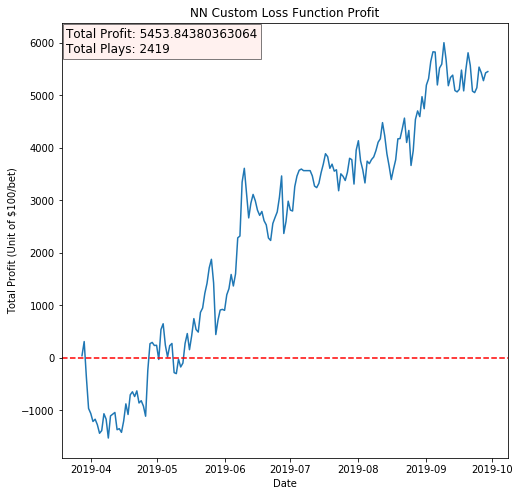

In [35]:
bc = BankrollCalculator(nn_preds, validation_target, validation_dates,
                       validation_home_closing, validation_road_closing, 
                        fig_title = "NN Custom Loss Function Profit",
                       save_fig = True, img_dest = "./neural_net/bankroll_images/deep_learning.png")

bc.plot_profit()

In [44]:
nnP = pd.Series(nn_preds).rename("plays")

wp = pd.concat([nnP, validation_target, validation_dates,
                       validation_home_closing, validation_road_closing], axis = 1)

In [47]:
all_dogs = wp[((wp.plays > 0.5) & (wp.home_closing > 0)) | 
             ((wp.plays < 0.5) & (wp.road_closing > 0))]

In [49]:
all_dogs = all_dogs.reset_index(drop = True)

In [50]:
all_dogs.head()

,plays,home_win,date,home_closing,road_closing
0,4.526347e-21,1,2019-03-28,-117.0,107.0
1,1.708183e-16,1,2019-03-28,-127.0,117.0
2,9.991376e-01,0,2019-03-30,110.0,-120.0
3,1.048959e-05,1,2019-03-30,-119.0,109.0
4,3.270865e-23,1,2019-03-30,-132.0,122.0


Graphic written to file ./neural_net/bankroll_images/only_dogs


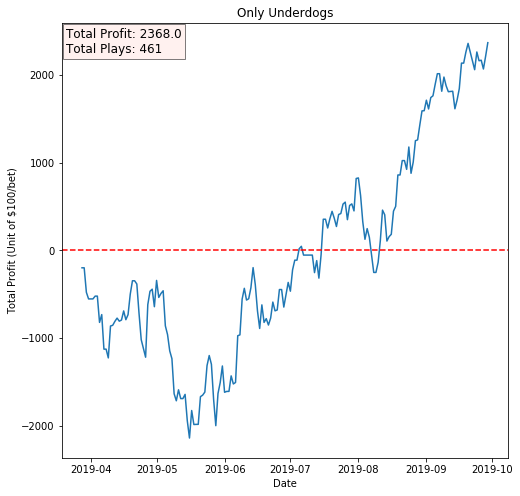

In [52]:
bc = BankrollCalculator(all_dogs.plays, all_dogs.home_win, all_dogs.date,
                       all_dogs.home_closing, all_dogs.road_closing, fig_title = "Only Underdogs",
                       save_fig = True, img_dest = "./neural_net/bankroll_images/only_dogs")

bc.plot_profit()

In [54]:
cols

Index(['home_OBPS', 'home_BULLPEN_ERA', 'road_OBPS', 'road_BULLPEN_ERA',
       'home_career_ERA_AH', 'road_career_ERA_OR', 'road_season_ERA_OR',
       'current_streak_hm_tm', 'home_record_hm', 'avg_margin_hm',
       'current_streak_rd_tm', 'current_streak_rd_tm_on_rd', 'rd_record_rd',
       'avg_margin_rd', 'home_opening', 'home_season_ERA_AH'],
      dtype='object')

In [47]:
#save model and model weights 
json_model = nn.model.to_json()
with open('nopca_custom.json', 'w+') as f:
    json.dump(json_model, f)
    
nn.model.save_weights("nopca_custom.h5")

# Dimensionality reduction
Try with current feature set and with normalized features

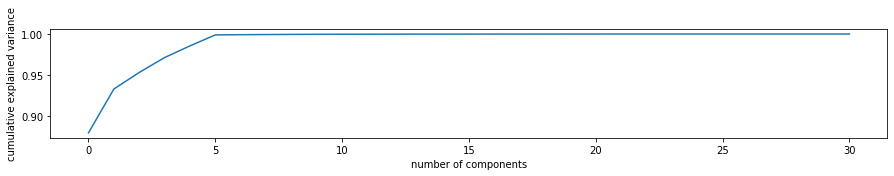

In [39]:
pca = PCA().fit(train_features)

plt.figure(figsize = (15, 2))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [40]:
explained_variance = pd.DataFrame(pca.explained_variance_ratio_)
explained_variance = explained_variance.rename(columns = {0 : 'var_proportion'})

explained_variance['total_variance_explained'] = explained_variance.var_proportion.cumsum()
explained_variance

,var_proportion,total_variance_explained
0,8.791073e-01,0.879107
1,5.363392e-02,0.932741
2,2.023602e-02,0.952977
3,1.822969e-02,0.971207
4,1.428957e-02,0.985497
5,1.341159e-02,0.998908
6,2.744626e-04,0.999183
7,1.873555e-04,0.999370
8,1.711722e-04,0.999541
9,1.085541e-04,0.999650


In [16]:
def feature_scaling(train, validation):
    ss = StandardScaler()
    col_names = list(train.columns)
    ss.fit(train)
    npX = ss.transform(train)
    npXV = ss.transform(validation)
    npX = pd.DataFrame(npX)
    npXV = pd.DataFrame(npXV)
    npX.columns = col_names
    npXV.columns = col_names
    return(npX, npXV)

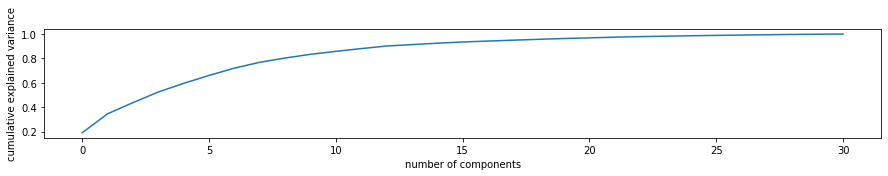

In [17]:
scaled_training, scaled_validation = feature_scaling(train_features, validation_input)
pca = PCA().fit(scaled_training)

plt.figure(figsize = (15, 2))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [18]:
explained_variance = pd.DataFrame(pca.explained_variance_ratio_)
explained_variance = explained_variance.rename(columns = {0 : 'var_proportion'})

explained_variance['total_variance_explained'] = explained_variance.var_proportion.cumsum()
explained_variance

,var_proportion,total_variance_explained
0,0.190345,0.190345
1,0.155915,0.346260
2,0.091298,0.437558
3,0.087076,0.524634
4,0.070971,0.595605
5,0.064834,0.660439
6,0.059929,0.720368
7,0.047855,0.768223
8,0.035120,0.803342
9,0.030324,0.833667


In [19]:
#reduce dimensions with both scaled and non-scaled features respectively
pca5 = PCA(n_components = 5).fit(train_features)
pca12 = PCA(n_components = 12).fit(scaled_training)

pca5_train = pca5.transform(train_features)
pca12_train = pca12.transform(scaled_training)
pca5_validation = pca5.transform(validation_input)
pca12_validation = pca12.transform(scaled_validation)

In [20]:
#convert datatypes for usage in modeling algorithms 
train_target = np.array(train_target).astype('float32')
validation_target = np.array(validation_target).astype('float32')

# Baseline Modeling
Train several different models and examine best performance before deciding next steps

Custom objective function

In [36]:
compile_params = {'optimizer' : 'adam', 'loss' : gambling_loss(train_odds1, train_odds2), 
                  'metrics' : ['binary_accuracy']}
es_params = {"monitor" : "loss", "patience" : 50, "restore_best_weights" : True, "mode" : "min"}

#train NeuralNetworks using custom loss function and updated early stopping params 
nn = NeuralNet(pca12_train, train_target, pca12_validation, validation_target, compile_params = compile_params, 
               early_stopping = True, early_stopping_params = es_params, dropout = False)
nn.train_predict()

Training complete


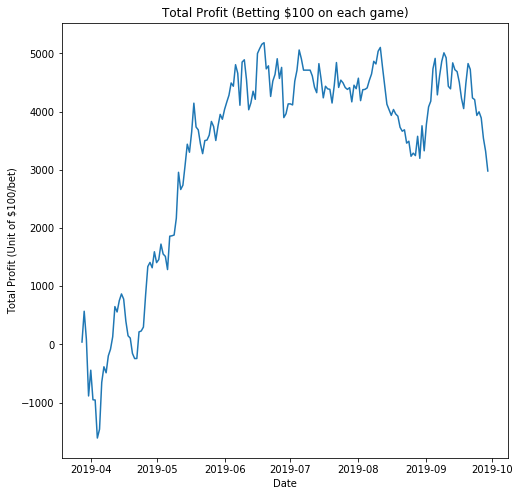

In [37]:
bc = BankrollCalculator(nn.validation_preds, validation_target, validation_dates, validation_home_closing,
                       validation_road_closing)
bc.plot_profit()

REMINDER! You selected the .play_some method... Extract play indices with .play_indices attr


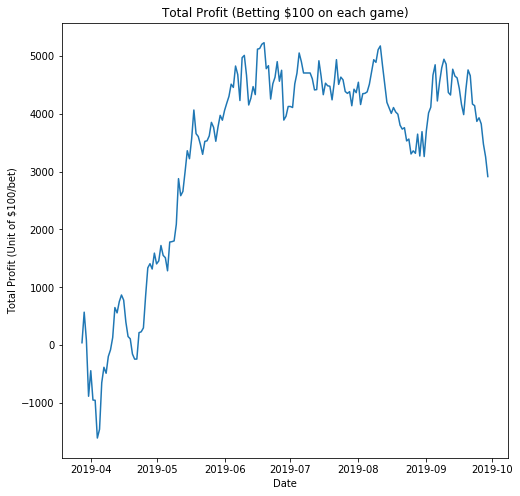

In [38]:
nn_preds = [i[0] for i in nn.validation_preds]
bc = BankrollCalculator(nn_preds, validation_target, validation_dates, validation_home_closing,
                       validation_road_closing, style = 'some')
bc.plot_profit()

In [39]:
strategy_play_indices[generate_key("pca12", "ES-ND-CUSTOMLOSS")] = bc.play_indices

In [40]:
#save model and model weights 
json_model = nn.model.to_json()
with open('customloss_model.json', 'w+') as f:
    json.dump(json_model, f)
    
nn.model.save_weights("customloss_weights.h5")

# IDEA: One loss function clearly predicts more favorites, one clearly predicts more underdogs. The loss function that favors underdogs performs better in the beginning of the season, the loss function that favors favorites performs better at the end of the season. Experiment with time series framework 

# Detour to look at season by season time series trends to determine if there is an effect 

In [41]:
moneyline_df['date'] = pd.to_datetime(moneyline_df.date, format = '%Y-%m-%d')

In [42]:
#create feature favorite win
favorite_win = []
for k in range(len(moneyline_df)):
    if (moneyline_df.iloc[k]['home_closing'] < 0 and moneyline_df.iloc[k]['home_win'] == 1) or \
    (moneyline_df.iloc[k]['road_closing'] < 0 and moneyline_df.iloc[k]['home_win'] == 0):
        favorite_win.append(1)
    else:
        favorite_win.append(0)

In [43]:
#append to main dataframe
favorite = pd.Series(favorite_win)
moneyline_df['favorite_win'] = favorite

In [44]:
def view_percentages(df, _type = "favorite"):
    years = df.year.unique()
    if _type == "favorite":
        metric = "favorite_win"
    elif _type == "home":
        metric = "home_win"
    for year in years:
        annual_frame = df[df.year == year].reset_index(drop = True)
        annual_frame = annual_frame.assign(n_games = 1)
        annual_frame = annual_frame[['date', metric , 'n_games']].set_index('date')
        annual_frame = annual_frame.resample('D').sum()
        fig, ax = plt.subplots(figsize= (10, 2))
        ax.plot(annual_frame.index, annual_frame[metric] / annual_frame.n_games)
        ax.set_xlabel('Date')
        ax.set_ylabel('Favorite Daily Winning Percentage {}'.format(str(year)))
        ax.set_title('Daily Favorite Winning Percentage for Year {}'.format(str(year)))
        ax.axhline(y = 0.5, c = 'r')

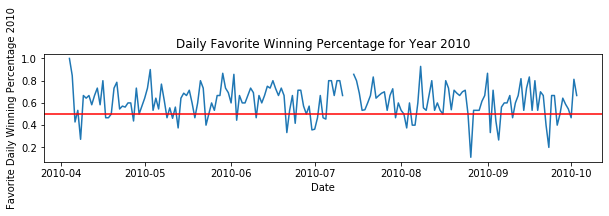

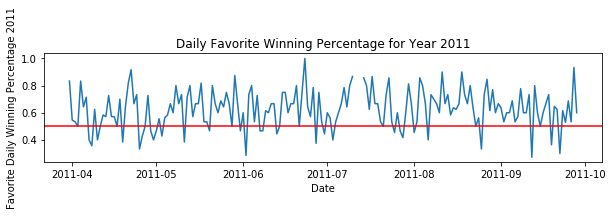

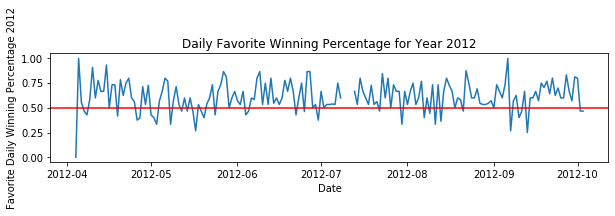

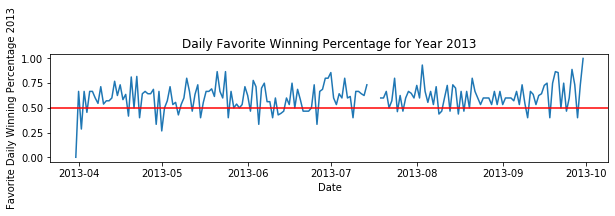

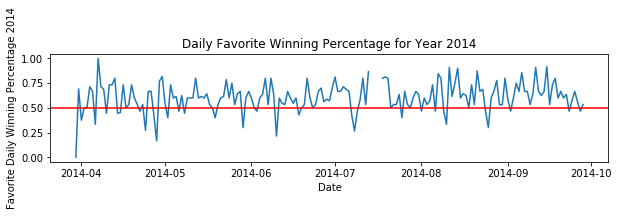

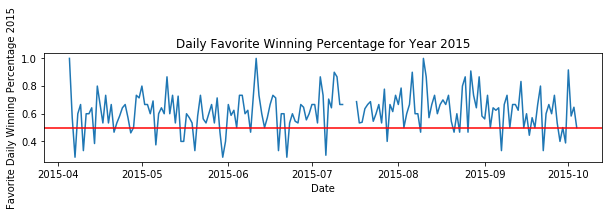

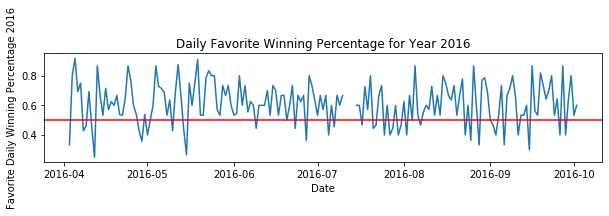

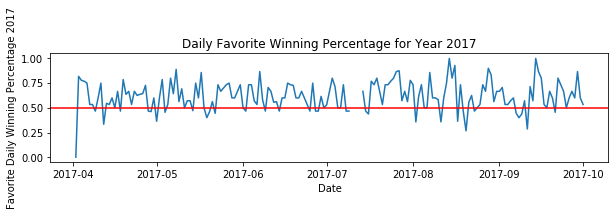

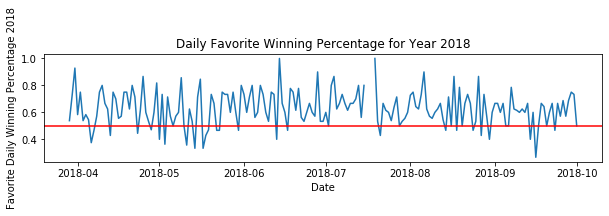

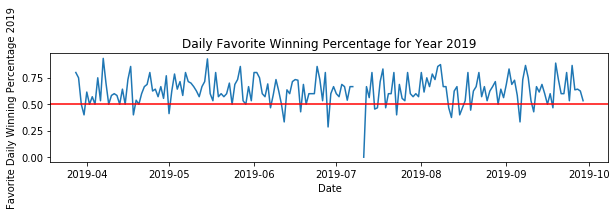

In [45]:
view_percentages(moneyline_df)

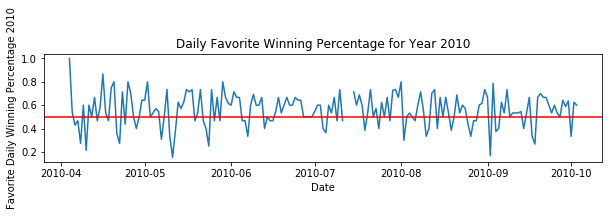

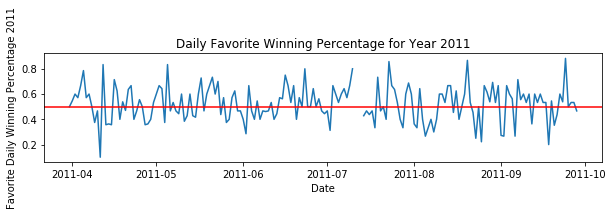

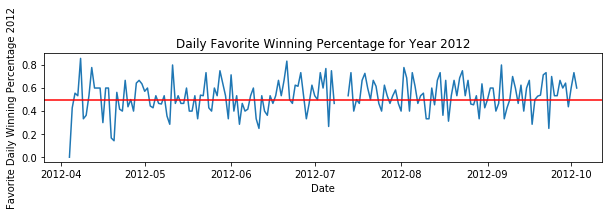

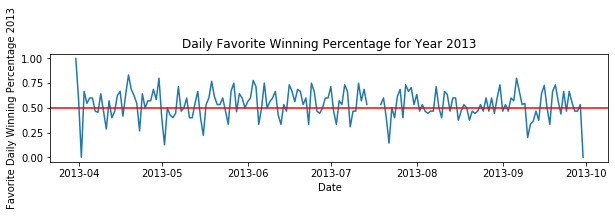

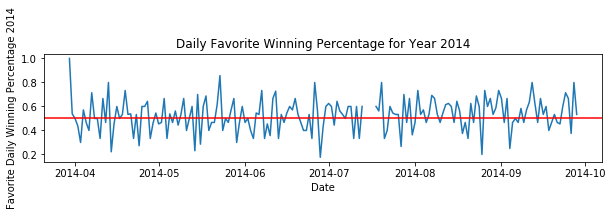

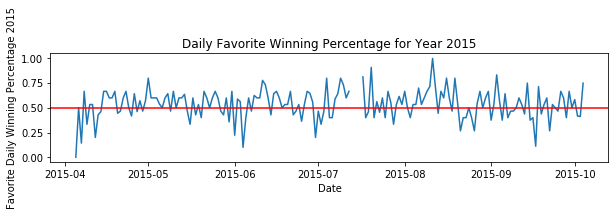

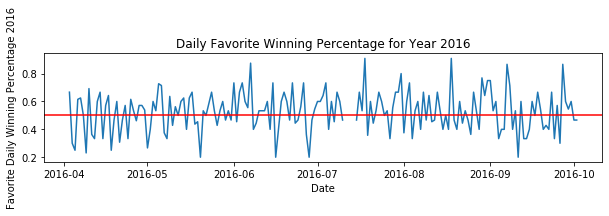

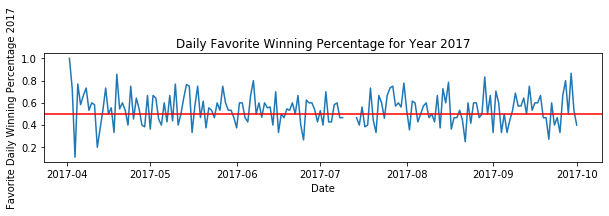

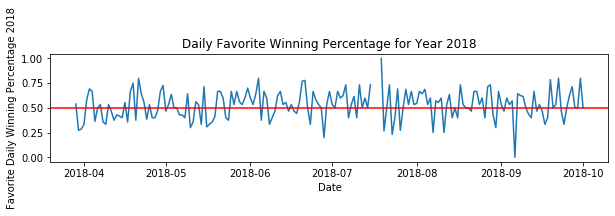

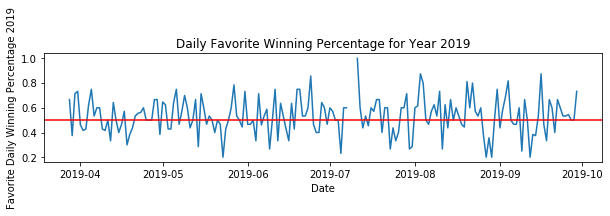

In [46]:
view_percentages(moneyline_df, _type = "home")

It is pretty clear that there is no season by season trend regarding either favorite winning percentage or home winning percentage. The potential time series effect is neglible. 